## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

Загрузим данные и сразу выполним ресемплирование по одному часу. Так же отсортируем время.

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df = df.resample('1H').sum()

In [3]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


Данные за период 6 месяцев: с 1 марта по 31 августа.

# 2. Анализ

Рассмотрим общее распределение.

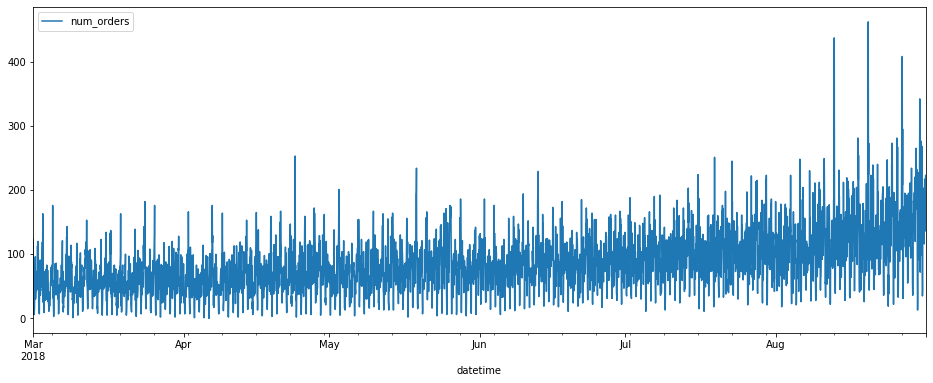

In [5]:
df.plot(figsize=(16, 6));

Посмотрим распределение по месяцам.

In [6]:
df_month = df.copy()
df_month.sort_index(inplace=True)
df_month = df_month.resample('1M').sum()
df_month

,num_orders
datetime,
2018-03-31,42768
2018-04-30,45939
2018-05-31,54820
2018-06-30,59906
2018-07-31,74405
2018-08-31,94973


Число заказов растет с марта по август. Особенно большой рост наблюдается в июле, августе - период отпусков.

Взглянем на тренды и сезонность.

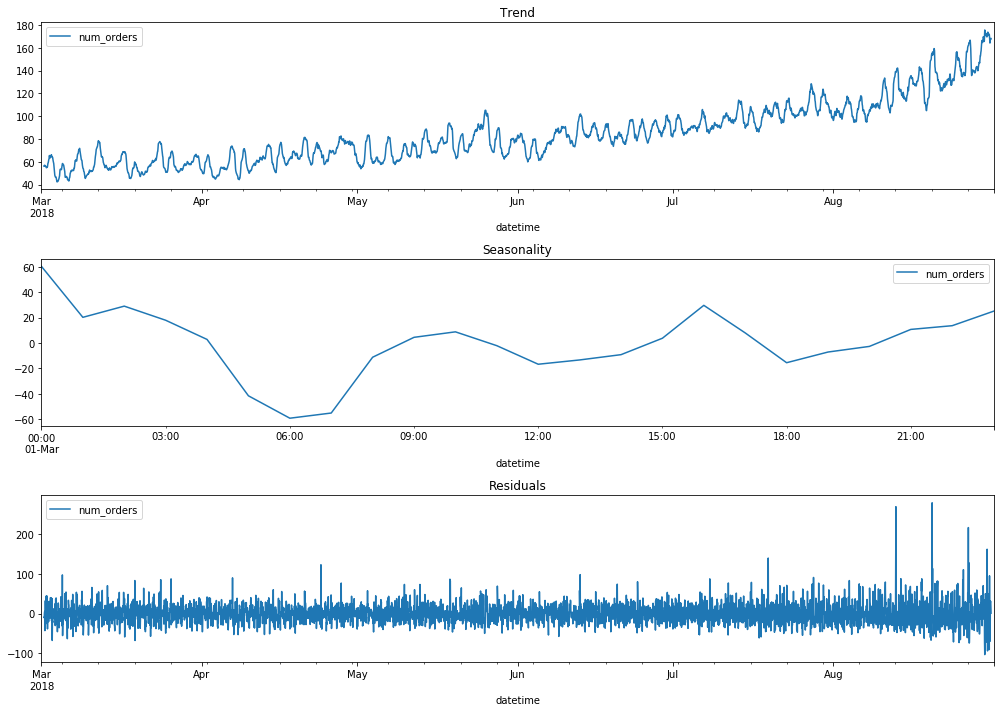

In [7]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(14, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-01'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Text(0.5, 1.0, 'Seasonality')

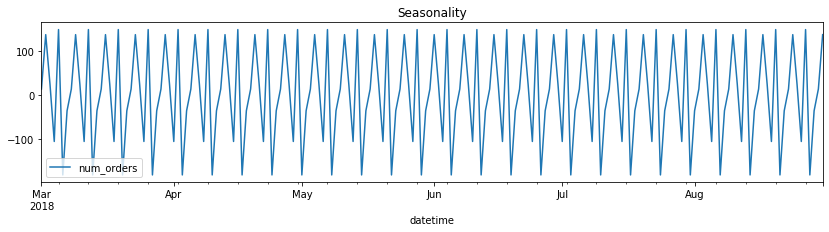

In [8]:
df_days = df.resample('1D').sum()
decomposed = seasonal_decompose(df_days)
plt.figure(figsize=(14, 10))
plt.subplot(312)
decomposed.seasonal['2018-03':'2018-08'].plot(ax=plt.gca())
plt.title('Seasonality')

По тренду видно, что есть рост с начала марта. В июле и августе он более значительный. Так как данные у нас за полгода, то сезонность рассмотрим в пределах дней. Сезонность распределена по часам: в 6 утра самый низкий уровень заказов,в 00:00 самая высокая загрузка, с 00:00 до 06:00 наблюдается снижение до минимума, с 06:00 до 14:00 рост, с небольшим провалом в 12:00, с 16:00 до 18:00 идет снижение, после 18:00 стабильный рост.

# 3. Обучение

Перед обучением добавим в данные признаки: календарные, отстающие значения и скользящее среднее.

In [9]:
def feature_create(data):
    # календарные признаки
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    # отстающие значения
    data['lag_1'] = data['num_orders'].shift(24)
    data['lag_2'] = data['num_orders'].shift(24*2)
    data['lag_3'] = data['num_orders'].shift(24*3)
    data['lag_4'] = data['num_orders'].shift(24*4)
    data['lag_5'] = data['num_orders'].shift(24*5)
    data['lag_6'] = data['num_orders'].shift(24*6)
    data['lag_7'] = data['num_orders'].shift(24*7)
    
    # скользящее среднее
    data['rolling_mean'] = data['num_orders'].shift().rolling(10).mean()

In [10]:
feature_create(df)
df

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,19,72.0,169.0,111.0,152.0,126.0,123.0,113.0,173.3
2018-08-31 20:00:00,154,2018,8,31,4,20,142.0,191.0,94.0,96.0,122.0,105.0,179.0,166.6
2018-08-31 21:00:00,159,2018,8,31,4,21,198.0,170.0,189.0,152.0,107.0,162.0,166.0,162.9


Разделим данные на обучающие и тестовые в соотношении 4:1. И в обущающих удалим Nan'ы.

In [11]:
df = df.dropna()
train, test = train_test_split(df, shuffle=False, test_size=0.2)
valid, test = train_test_split(test, shuffle=False, test_size=0.5)

In [12]:
train

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,2018,3,8,3,0,100.0,42.0,86.0,75.0,163.0,90.0,124.0,74.2
2018-03-08 01:00:00,78,2018,3,8,3,1,121.0,75.0,176.0,60.0,108.0,120.0,85.0,84.2
2018-03-08 02:00:00,65,2018,3,8,3,2,24.0,36.0,32.0,26.0,25.0,75.0,71.0,86.9
2018-03-08 03:00:00,68,2018,3,8,3,3,66.0,49.0,51.0,42.0,64.0,64.0,66.0,88.8
2018-03-08 04:00:00,60,2018,3,8,3,4,73.0,30.0,34.0,27.0,44.0,20.0,43.0,90.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-27 09:00:00,139,2018,7,27,4,9,138.0,122.0,114.0,152.0,74.0,102.0,137.0,112.3
2018-07-27 10:00:00,149,2018,7,27,4,10,142.0,95.0,94.0,94.0,54.0,81.0,137.0,114.5
2018-07-27 11:00:00,110,2018,7,27,4,11,86.0,93.0,88.0,136.0,80.0,124.0,110.0,107.2


In [13]:
valid

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,,,
2018-07-27 14:00:00,61,2018,7,27,4,14,53.0,95.0,116.0,86.0,114.0,86.0,98.0,104.4
2018-07-27 15:00:00,113,2018,7,27,4,15,104.0,119.0,114.0,118.0,114.0,117.0,67.0,99.6
2018-07-27 16:00:00,162,2018,7,27,4,16,142.0,134.0,112.0,127.0,136.0,198.0,121.0,104.5
2018-07-27 17:00:00,160,2018,7,27,4,17,113.0,121.0,120.0,136.0,128.0,107.0,143.0,112.9
2018-07-27 18:00:00,76,2018,7,27,4,18,84.0,68.0,118.0,73.0,52.0,38.0,108.0,124.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-14 02:00:00,108,2018,8,14,1,2,437.0,157.0,175.0,201.0,211.0,157.0,125.0,134.1
2018-08-14 03:00:00,190,2018,8,14,1,3,168.0,136.0,171.0,80.0,114.0,104.0,121.0,130.5
2018-08-14 04:00:00,139,2018,8,14,1,4,143.0,111.0,126.0,122.0,144.0,104.0,108.0,134.3


In [14]:
test

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,,,
2018-08-14 07:00:00,54,2018,8,14,1,7,39.0,24.0,33.0,62.0,28.0,27.0,44.0,129.7
2018-08-14 08:00:00,91,2018,8,14,1,8,91.0,97.0,106.0,67.0,78.0,113.0,79.0,119.1
2018-08-14 09:00:00,135,2018,8,14,1,9,137.0,108.0,120.0,81.0,139.0,122.0,120.0,117.8
2018-08-14 10:00:00,155,2018,8,14,1,10,156.0,108.0,140.0,153.0,149.0,130.0,99.0,117.9
2018-08-14 11:00:00,162,2018,8,14,1,11,144.0,81.0,81.0,167.0,85.0,110.0,71.0,119.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,19,72.0,169.0,111.0,152.0,126.0,123.0,113.0,173.3
2018-08-31 20:00:00,154,2018,8,31,4,20,142.0,191.0,94.0,96.0,122.0,105.0,179.0,166.6
2018-08-31 21:00:00,159,2018,8,31,4,21,198.0,170.0,189.0,152.0,107.0,162.0,166.0,162.9


In [15]:
print('Размер выборки train:', train.shape)
print('Размер выборки valid:', valid.shape)
print('Размер выборки test:', test.shape)

Размер выборки train: (3398, 14)
Размер выборки valid: (425, 14)
Размер выборки test: (425, 14)


Выделим признаки и целевой признак.

In [16]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_valid = valid.drop('num_orders', axis=1)
target_valid = valid['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Проверим разбивку.

In [17]:
print('Размер выборки features_train:', features_train.shape)
print('Размер выборки target_train:', target_train.shape)
print('Размер выборки features_train:', features_valid.shape)
print('Размер выборки target_train:', target_valid.shape)
print('Размер выборки features_train:', features_test.shape)
print('Размер выборки target_train:', target_test.shape)

Размер выборки features_train: (3398, 13)
Размер выборки target_train: (3398,)
Размер выборки features_train: (425, 13)
Размер выборки target_train: (425,)
Размер выборки features_train: (425, 13)
Размер выборки target_train: (425,)


Масштабируем данные.

In [18]:
numeric = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'rolling_mean']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric]).copy()
features_valid[numeric] = scaler.transform(features_valid[numeric]).copy()
features_test[numeric] = scaler.transform(features_test[numeric]).copy()

# 3.1 Линейная регрессия

In [19]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
predict_lr = model_lr.predict(features_valid)

results = []
results.append({'Модель': 'LinearRegression', 
                'Параметры': np.nan, 
                'RMSE': mean_squared_error(target_valid, predict_lr)**0.5})

pd.DataFrame(results)

,Модель,Параметры,RMSE
0,LinearRegression,NaN,29.842382


Хороший результат линейной регрессии. RMSE равна 39, укладываемся в условия задачи.

# 3.2 Случайный лес

In [20]:
for depth in range(1,15):
    
    for estimator in range(10, 221, 10):
        
        model_rf = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
        model_rf.fit(features_train, target_train)
        predict_rf = model_rf.predict(features_valid)
        results.append({'Модель': 'RandomForestRegressor', 
                'Параметры': "Колво деревьев-" + str(estimator) + ";" + "Глубина-" + str(depth), 
                'RMSE': mean_squared_error(target_valid, predict_rf)**0.5})

pd.DataFrame(results)

,Модель,Параметры,RMSE
0,LinearRegression,NaN,29.842382
1,RandomForestRegressor,Колво деревьев-10;Глубина-1,44.701542
2,RandomForestRegressor,Колво деревьев-20;Глубина-1,45.034081
3,RandomForestRegressor,Колво деревьев-30;Глубина-1,44.525862
4,RandomForestRegressor,Колво деревьев-40;Глубина-1,44.725135
...,...,...,...
304,RandomForestRegressor,Колво деревьев-180;Глубина-14,30.373393
305,RandomForestRegressor,Колво деревьев-190;Глубина-14,30.060746
306,RandomForestRegressor,Колво деревьев-200;Глубина-14,30.293590
307,RandomForestRegressor,Колво деревьев-210;Глубина-14,30.121525


# 3.3 LGBMRegressor

In [21]:
for depth in range(1,15):
    
    for estimator in range(10, 221, 10):
        
        model_lgbm = LGBMRegressor(boosting_type='gbdt', max_depth=depth, n_estimators=estimator, learning_rate=0.17)
        model_lgbm.fit(features_train, target_train)
        predict_lgbm = model_lgbm.predict(features_valid)
        results.append({'Модель': 'LGBMRegressor', 
                'Параметры': "Колво деревьев-" + str(estimator) + ";" + "Глубина-" + str(depth), 
                'RMSE': mean_squared_error(target_valid, predict_lgbm)**0.5})

pd.DataFrame(results)

,Модель,Параметры,RMSE
0,LinearRegression,NaN,29.842382
1,RandomForestRegressor,Колво деревьев-10;Глубина-1,44.701542
2,RandomForestRegressor,Колво деревьев-20;Глубина-1,45.034081
3,RandomForestRegressor,Колво деревьев-30;Глубина-1,44.525862
4,RandomForestRegressor,Колво деревьев-40;Глубина-1,44.725135
...,...,...,...
612,LGBMRegressor,Колво деревьев-180;Глубина-14,31.479619
613,LGBMRegressor,Колво деревьев-190;Глубина-14,31.527718
614,LGBMRegressor,Колво деревьев-200;Глубина-14,31.546629
615,LGBMRegressor,Колво деревьев-210;Глубина-14,31.602937


In [22]:
res = pd.DataFrame(results)
print(res[res['RMSE']==res['RMSE'].min()])

             Модель Параметры       RMSE
0  LinearRegression       NaN  29.842382


В результате линейная регрессия показала лучший результат на валидационной выборке исходя из RMSE. В порог RMSE 48 мы уложилиcь.

# 4. Тестирование

Протестируем лучшую модель на тестовой выборке.

In [27]:
predict_lr = model_lr.predict(features_test)
print("RMSE линейная регрессия:", mean_squared_error(target_test, predict_lr)**0.5)

RMSE линейная регрессия: 34.52243737800323


Наилучший результат показала модель линейной регрессии.

Вывод: мы загрузили данные, выполнили их ресемплирование по одному часу. Выявили тренд: рост идет с начала марта, особенно большой рост в июле и августе, что логично, это период отпусков. Сезонность распределена по часам: в какой то час дня заказов много, в какой-то меньше. Были созданы признаки для обучения и обучены три модели: линейная регрессия, случайный лес и LGBMRegressor. После тестирования лучшее значение RMSE у модели линейной регрессии.